# Numerical Experiments : Results 

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import itertools
import pandas as pd


In [3]:
# Assuming the JSON file is named 'data.json' and is in the same directory as the notebook
with open('results.json', 'r') as file:
    data = json.load(file)


In [14]:
z_star  = np.array(data['z_star'])
z_tilde = np.array(data['z_tilde']).T
times   = np.array(data['time']).T

In [5]:
metric = np.zeros((z_tilde.shape[0], z_tilde.shape[1]))
labels = ["OptVax1", "OptVax2", "OptVax2LP", "Greedy + LS", "OptVax1 + G-LS", "OptVax2 + G-LS"]
z_relax = z_tilde[2, :]

for l in range(z_tilde.shape[0]):
    for k in range(z_tilde.shape[1]):
        metric[l,k] = np.abs(z_tilde[l,k] - z_relax[k])*(times[l,k])


## Metric Plot

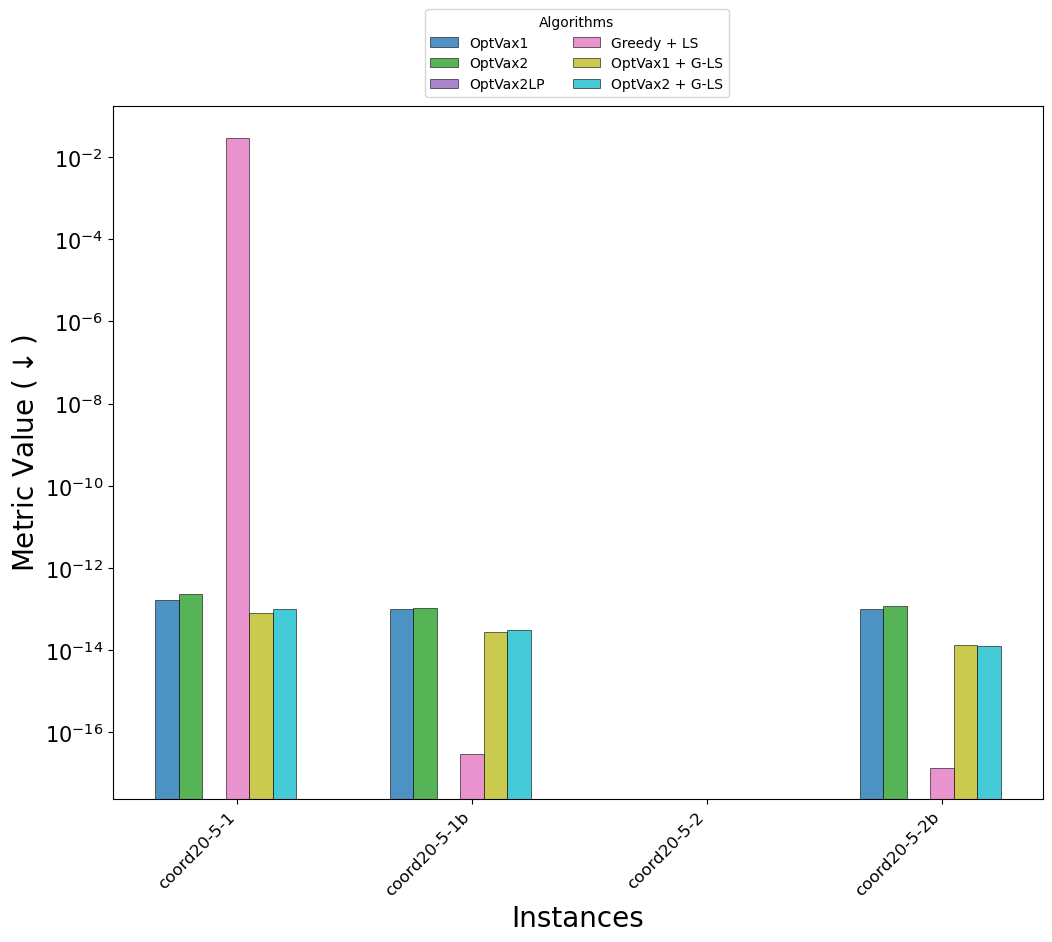

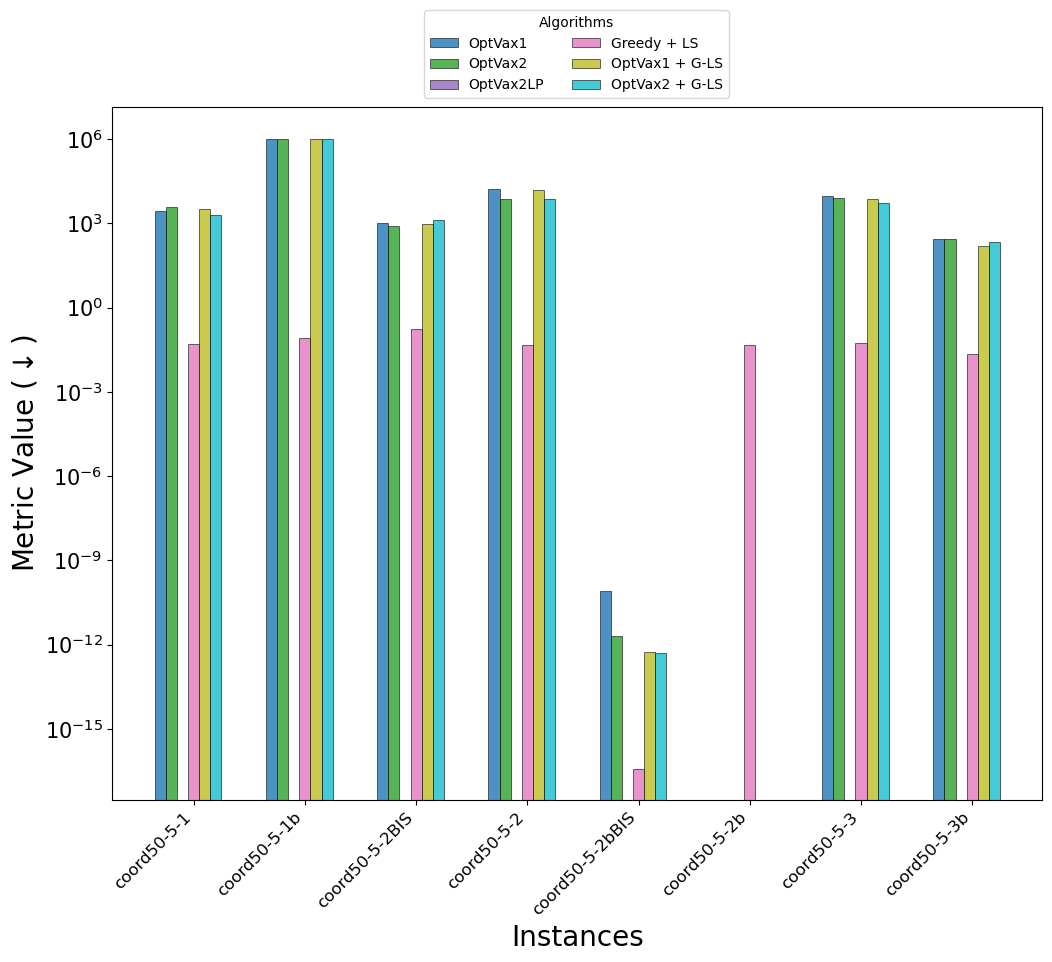

In [6]:

labels = ["OptVax1", "OptVax2", "OptVax2LP", "Greedy + LS", "OptVax1 + G-LS", "OptVax2 + G-LS"]
names_20 = ["coord20-5-1", "coord20-5-1b", "coord20-5-2", "coord20-5-2b"]
names_50 = ["coord50-5-1", "coord50-5-1b", "coord50-5-2BIS", "coord50-5-2", "coord50-5-2bBIS", "coord50-5-2b", "coord50-5-3", "coord50-5-3b"]

fig1, ax1 = plt.subplots(1, 1, figsize=(12, 9))

bar_width = 0.10  # Width of each sub-bar
x_positions = np.arange(len(names_20))  # X-axis positions for main groups
k_colors = plt.cm.tab10(np.linspace(0, 1, metric.shape[0]))  # Unique colors for k values

# Plot for instances of size 20
for i, name in enumerate(names_20):
    for k in range(z_tilde.shape[0]):
        offset = k * bar_width - (z_tilde.shape[0] / 2) * bar_width  # Center sub-bars within each group
        if i == 0:
            ax1.bar(x_positions[i] + offset, metric[k, i], width=bar_width, color=k_colors[k], alpha=0.8, label=f"{labels[k]}", edgecolor="black", linewidth=0.5)
        else:
            ax1.bar(x_positions[i] + offset, metric[k, i], width=bar_width, color=k_colors[k], alpha=0.8, edgecolor="black", linewidth=0.5)

# ax1.hlines(1e-2, -3*bar_width - bar_width/2, len(names_20)-1 + 2*bar_width + bar_width/2, color="black", linestyles="--",linewidth=1.5)
ax1.set_xticks(x_positions)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_xticklabels(names_20, rotation=45, ha="right", fontsize=12)
ax1.set_ylabel(r"Metric Value ($\downarrow$)", fontsize=20)
ax1.set_xlabel("Instances",    fontsize=20)
ax1.set_yscale("log")  # Optional: Use a log scale for better value comparison

ax1.legend(loc="upper right", ncols=2, title="Algorithms", bbox_to_anchor=(0.67, 1.15))

plt.savefig("metric_20.pdf", dpi = 300, bbox_inches='tight')

fig2, ax2 = plt.subplots(1, 1, figsize=(12, 9))

bar_width = 0.10  # Width of each sub-bar
x_positions = np.arange(len(names_50))  # X-axis positions for main groups
k_colors = plt.cm.tab10(np.linspace(0, 1, metric.shape[0])) 

# Plot for instances of size 50
for i, name in enumerate(names_50):
    for k in range(z_tilde.shape[0]):
        offset = k * bar_width - (z_tilde.shape[0] / 2) * bar_width  # Center sub-bars within each group
        if i == 0:
            ax2.bar(x_positions[i] + offset, metric[k, i+4], width=bar_width, color=k_colors[k], alpha=0.8, label=f"{labels[k]}", edgecolor="black", linewidth=0.5)
        else:
            ax2.bar(x_positions[i] + offset, metric[k, i+4], width=bar_width, color=k_colors[k], alpha=0.8, edgecolor="black", linewidth=0.5)

# ax2.hlines(1e-2, -3*bar_width - bar_width/2, len(names_50)-1 + 2*bar_width + bar_width/2, color="black", linestyles="--", label="Solved", linewidth=1.5)

ax2.set_xticks(x_positions)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_xticklabels(names_50, rotation=45, ha="right", fontsize=12)
ax2.set_ylabel(r"Metric Value ($\downarrow$)", fontsize=20)
ax2.set_xlabel("Instances",    fontsize=20)
ax2.set_yscale("log")
handles, legends = ax1.get_legend_handles_labels()
new_order = list(range(len(handles) - 1)) + [len(handles) - 1]
ax2.legend([handles[i] for i in new_order], [legends[i] for i in new_order], loc="upper right", ncols=2, title="Algorithms", bbox_to_anchor=(0.67, 1.15))
# ax2.legend(loc="upper right", ncols=2, title="Algorithms", bbox_to_anchor=(0.65, 1.2))

plt.savefig("metric_50.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## Time Plot

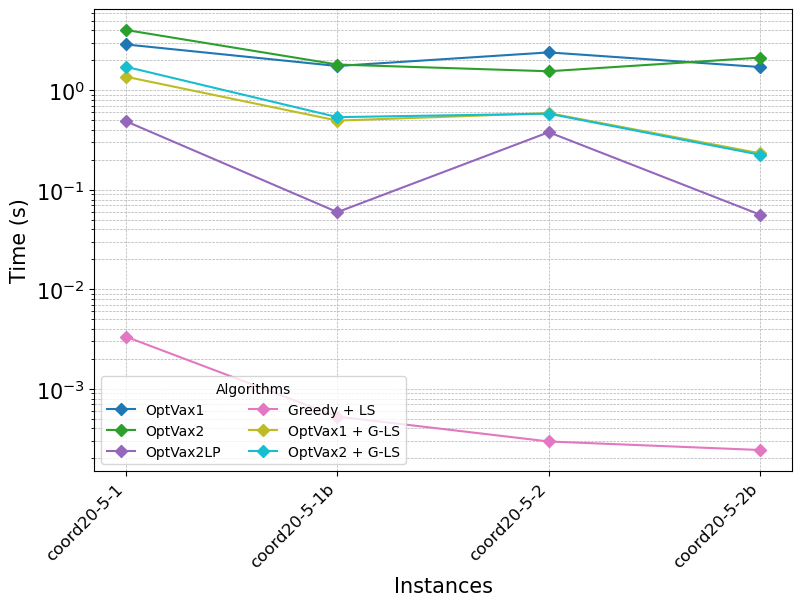

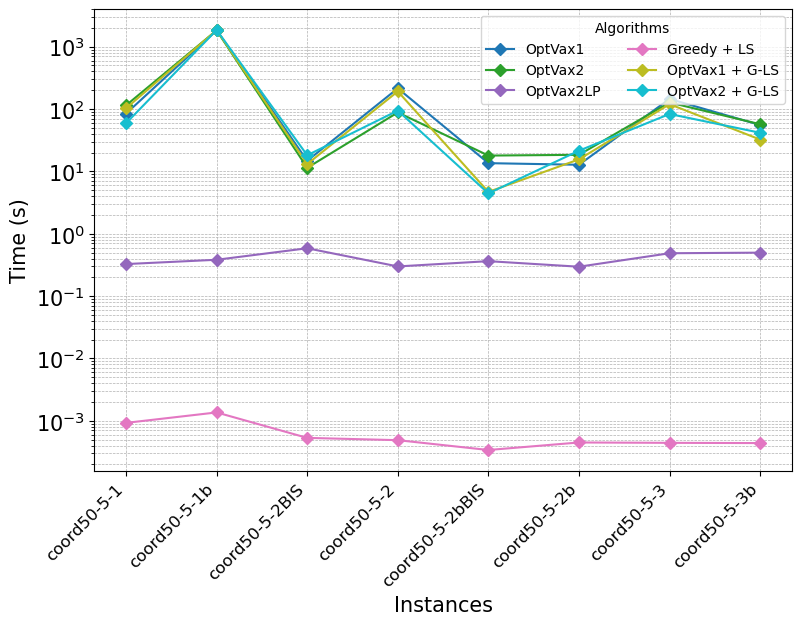

In [7]:
labels = ["OptVax1", "OptVax2", "OptVax2LP", "Greedy + LS", "OptVax1 + G-LS", "OptVax2 + G-LS"]
names_20 = ["coord20-5-1", "coord20-5-1b", "coord20-5-2", "coord20-5-2b"]
names_50 = ["coord50-5-1", "coord50-5-1b", "coord50-5-2BIS", "coord50-5-2", "coord50-5-2bBIS", "coord50-5-2b", "coord50-5-3", "coord50-5-3b"]

fig1, ax1 = plt.subplots(1, 1, figsize=(9, 6))
x_positions = np.arange(len(names_20)) + 0.5
k_colors = plt.cm.tab10(np.linspace(0, 1, metric.shape[0])) 

for i, label in enumerate(labels):
    ax1.plot(x_positions, times[i, :len(names_20)], marker="D", label=label, color = k_colors[i])

ax1.legend(title="Algorithms", ncols=2)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(names_20, rotation=45, ha="right", fontsize=12)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylabel("Time (s)", fontsize=15)
ax1.set_yscale("log")
ax1.set_xlabel("Instances", fontsize=15)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig("time_20.pdf", dpi = 300, bbox_inches='tight')

fig2, ax2 = plt.subplots(1, 1, figsize=(9, 6))
x_positions = np.arange(len(names_50))  + .5

for i, label in enumerate(labels):
    ax2.plot(x_positions, times[i, len(names_20):], marker="D", label=label, color = k_colors[i])

ax2.legend(title="Algorithms", ncols=2)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(names_50, rotation=45, ha="right", fontsize=12)
ax2.set_ylabel("Time (s)", fontsize=15)
ax2.set_xlabel("Instances", fontsize=15)
ax2.set_yscale("log")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig("time_50.pdf", dpi = 300, bbox_inches='tight')



## Relevance Test

In [8]:
# Create all possible pairs of methods (i, j) for comparison
pairs = list(itertools.combinations(range(metric.shape[0]), 2))
labels = ["OptVax1", "OptVax2", "OptVax2LP", "Greedy + LS", "OptVax1 + G-LS", "OptVax2 + G-LS"]

results_matrix = pd.DataFrame(index=labels, columns=labels)

for i, j in pairs:
    method_1 = metric[i, :]
    method_2 = metric[j, :]

    stat, p_value = mannwhitneyu(method_1, method_2, alternative='two-sided')

    # Store the p-value result in the matrix
    results_matrix.iloc[i, j] = f"{p_value:.4e}"
    results_matrix.iloc[j, i] = f"{p_value:.4e}"


In [9]:
np.fill_diagonal(results_matrix.values, 'N/A')

# Generate LaTeX table using Pandas
latex_table = results_matrix.to_latex(index=True, float_format="%.4e", caption="Pairwise Mann-Whitney U test p-values for different methods.", label="table:mann_whitney_results")

print("\nGenerated LaTeX Table:\n")
print(latex_table)


Generated LaTeX Table:

\begin{table}
\caption{Pairwise Mann-Whitney U test p-values for different methods.}
\label{table:mann_whitney_results}
\begin{tabular}{lllllll}
\toprule
 & OptVax1 & OptVax2 & OptVax2LP & Greedy + LS & OptVax1 + G-LS & OptVax2 + G-LS \\
\midrule
OptVax1 & N/A & 1.0000e+00 & 1.2531e-04 & 3.4036e-01 & 7.5031e-01 & 7.5031e-01 \\
OptVax2 & 1.0000e+00 & N/A & 1.2531e-04 & 3.4036e-01 & 8.3952e-01 & 7.5031e-01 \\
OptVax2LP & 1.2531e-04 & 1.2531e-04 & N/A & 3.7585e-05 & 1.2531e-04 & 1.2531e-04 \\
Greedy + LS & 3.4036e-01 & 3.4036e-01 & 3.7585e-05 & N/A & 3.4036e-01 & 3.4036e-01 \\
OptVax1 + G-LS & 7.5031e-01 & 8.3952e-01 & 1.2531e-04 & 3.4036e-01 & N/A & 1.0000e+00 \\
OptVax2 + G-LS & 7.5031e-01 & 7.5031e-01 & 1.2531e-04 & 3.4036e-01 & 1.0000e+00 & N/A \\
\bottomrule
\end{tabular}
\end{table}

